# Actividad 4 — Redes Neuronales 

In [1]:
import numpy as np
import pandas as pd
import time
import math

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


from utils import * 

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [2]:
df = pd.read_csv("data-churn.csv")
target = None
for cand in ["Churn", "churn", "Exited", "Target", "target"]:
    if cand in df.columns:
        target = cand
        break

assert target is not None, "No se encontró columna objetivo. Ajusta el nombre de la variable objetivo."

# Map si está en formato Yes/No
if df[target].dtype == "object":
    df[target] = df[target].map({"Yes": 1, "No": 0, "yes": 1, "no": 0}).astype("float")

df[target] = df[target].astype(int)

df.head(), df[target].value_counts(normalize=True)


(   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 3  No phone service             DSL            Yes  ...              Yes   
 4                No     Fiber optic             No  ...               No   
 
   TechSupport StreamingTV StreamingMovies      

## 2) Preprocesamiento (imputación + one-hot + escalamiento)


In [3]:
X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train = preprocessor.fit_transform(X_train_raw)
X_test  = preprocessor.transform(X_test_raw)

X_train.shape, X_test.shape


((5634, 10954), (1409, 10954))

## 3) Dataset PyTorch (tabular)

In [4]:
train_ds = TabularDataset(X_train, y_train)
test_ds  = TabularDataset(X_test, y_test)

len(train_ds), len(test_ds)


(5634, 1409)

## 4) Modelo 1: MLP (Perceptrón Multi-Capa)

### 4.1) Entrenamiento base MLP

In [5]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

train_loader = DataLoader(TabularDataset(X_tr, y_tr), batch_size=32, shuffle=True)
val_loader   = DataLoader(TabularDataset(X_val, y_val), batch_size=256, shuffle=False)

mlp = MLP(input_dim=X_train.shape[1], hidden_dims=(64, 32), dropout=0.1)

epoch 01 | train_loss=0.5114 | val_loss=0.4342
epoch 05 | train_loss=0.0607 | val_loss=0.4982
epoch 10 | train_loss=0.0020 | val_loss=0.4958
epoch 15 | train_loss=0.0004 | val_loss=0.5223
epoch 20 | train_loss=0.0002 | val_loss=0.5516
epoch 25 | train_loss=0.0001 | val_loss=0.6822
train_time(s)=28.02


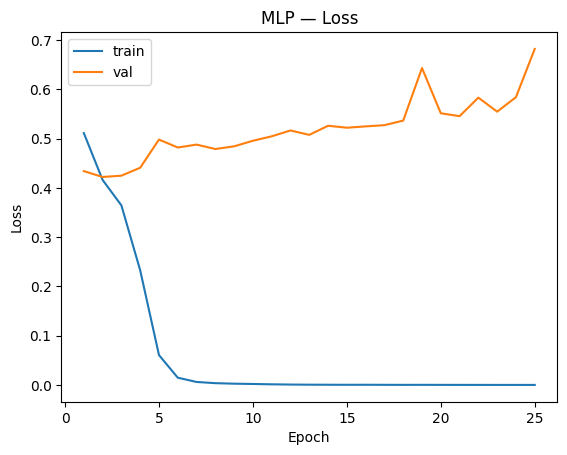

accuracy     0.723918
precision    0.487603
recall       0.788770
f1           0.602656
auc_roc      0.813775
pr_auc       0.601282
dtype: float64

In [6]:
hist, train_time = train_torch_binary(mlp, train_loader, val_loader, lr=1e-3, epochs=25, verbose=True)
print(f"train_time(s)={train_time:.2f}")

# Curva de pérdida
fig, ax = plt.subplots()
ax.plot(hist["epoch"], hist["train_loss"], label="train")
ax.plot(hist["epoch"], hist["val_loss"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("MLP — Loss")
ax.legend()
plt.show()

# Métricas en test
y_prob = predict_proba_torch(mlp, X_test)
metrics, y_pred = binary_classification_metrics(y_test.values, y_prob)
pd.Series(metrics)


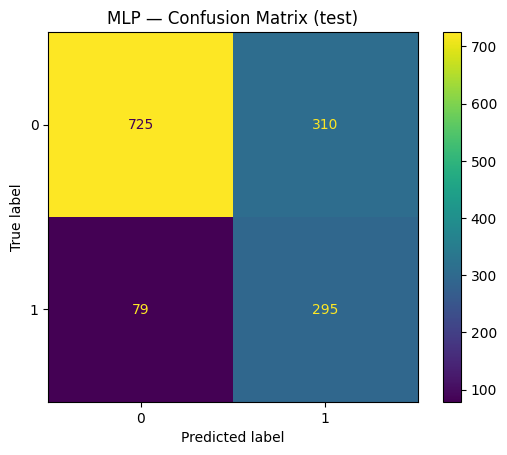

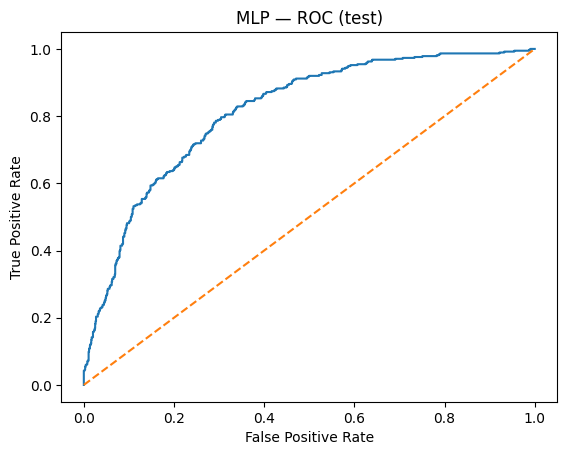

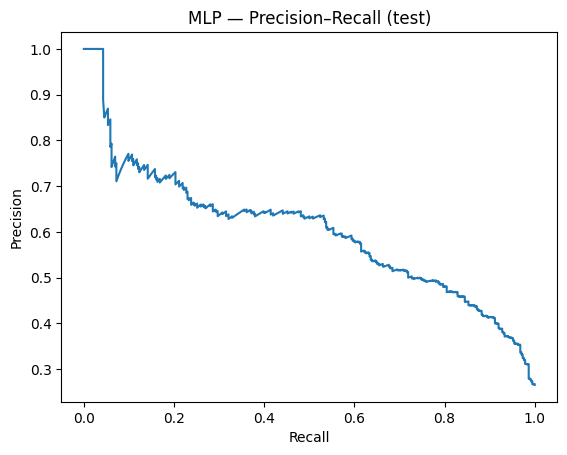

In [7]:
plot_confusion(y_test.values, y_pred, title="MLP — Confusion Matrix (test)")
plot_roc_pr(y_test.values, y_prob, title="MLP")


## 5) Paso 2: Experimentos (learning rate y batch size)

In [8]:
lrs = [1e-3]
batches = [16]

rows = []
histories = {}

for lr in lrs:
    for bs in batches:
        row, hist = run_mlp_experiment(lr, bs, X_tr, y_tr, X_val, y_val, 
                                       X_test, y_test, X_train,
                                       epochs=20)
        rows.append(row)
        histories[(lr, bs)] = hist

results_mlp = pd.DataFrame(rows).sort_values(["lr", "batch_size"])
results_mlp


,lr,batch_size,train_time_s,accuracy,precision,recall,f1,auc_roc,pr_auc
0,0.001,16,34.848933,0.765082,0.55443,0.585561,0.569571,0.809055,0.595897


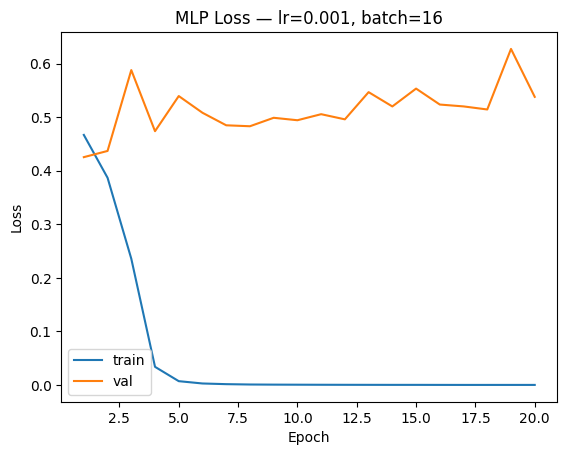

In [9]:
for (lr, bs), hist in histories.items():
    fig, ax = plt.subplots()
    ax.plot(hist["epoch"], hist["train_loss"], label="train")
    ax.plot(hist["epoch"], hist["val_loss"], label="val")
    ax.set_title(f"MLP Loss — lr={lr}, batch={bs}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    plt.show()


## 6) Modelo 2: CNN sobre representación matricial del churn

In [10]:
X_train_img, side, p = to_image_like(X_train)
X_test_img, _, _ = to_image_like(X_test)

side, p, X_train_img.shape


(105, 10954, (5634, 1, 105, 105))

In [11]:
class ImageLikeDataset(Dataset):
    def __init__(self, X_img, y_np):
        self.X = torch.tensor(X_img, dtype=torch.float32)
        self.y = torch.tensor(y_np.values if hasattr(y_np, "values") else y_np, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SimpleCNN(nn.Module):
    def __init__(self, side, conv1=8, conv2=16):
        super().__init__()
        # stride=1, padding=1 para mantener tamaño en cada conv
        self.features = nn.Sequential(
            nn.Conv2d(1, conv1, kernel_size=3, stride=1, padding=1),  # kernels + stride + padding
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # pooling
            nn.Conv2d(conv1, conv2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        # calcular tamaño flatten
        with torch.no_grad():
            x = torch.zeros(1, 1, side, side)
            z = self.features(x)
            flat = int(np.prod(z.shape[1:]))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        z = self.features(x)
        return self.classifier(z)

@torch.no_grad()
def predict_proba_torch_img(model, X_img, batch_size=512):
    model.eval()
    probs = []
    loader = DataLoader(torch.tensor(X_img, dtype=torch.float32), batch_size=batch_size, shuffle=False)
    for xb in loader:
        xb = xb.to(device)
        logits = model(xb)
        p = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
        probs.append(p)
    return np.concatenate(probs)


epoch 01 | train_loss=0.5677 | val_loss=0.5256
epoch 05 | train_loss=0.3959 | val_loss=0.4662
epoch 10 | train_loss=0.3228 | val_loss=0.5396
epoch 15 | train_loss=0.2020 | val_loss=0.7128
epoch 20 | train_loss=0.0671 | val_loss=1.3703
epoch 25 | train_loss=0.0276 | val_loss=1.9090
train_time(s)=171.83


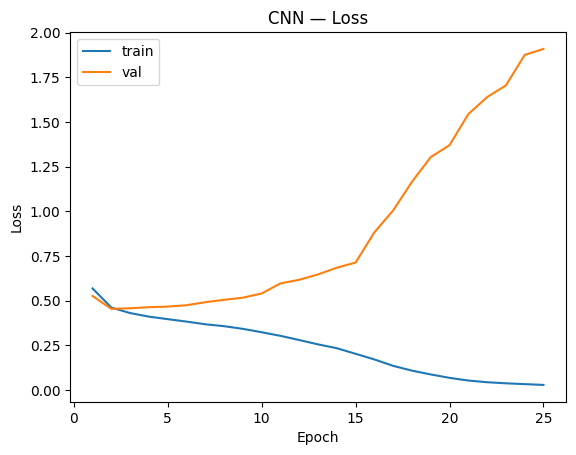

accuracy     0.712562
precision    0.476263
recall       0.831551
f1           0.605648
auc_roc      0.791745
pr_auc       0.497728
dtype: float64

In [12]:
X_tr_i, X_val_i, y_tr_i, y_val_i = train_test_split(
    X_train_img, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

cnn_train_loader = DataLoader(ImageLikeDataset(X_tr_i, y_tr_i), batch_size=32, shuffle=True)
cnn_val_loader   = DataLoader(ImageLikeDataset(X_val_i, y_val_i), batch_size=256, shuffle=False)

cnn = SimpleCNN(side=side, conv1=8, conv2=16)

hist_cnn, dt_cnn = train_torch_binary(cnn, cnn_train_loader, cnn_val_loader, lr=1e-3, epochs=25, verbose=True)
print(f"train_time(s)={dt_cnn:.2f}")

fig, ax = plt.subplots()
ax.plot(hist_cnn["epoch"], hist_cnn["train_loss"], label="train")
ax.plot(hist_cnn["epoch"], hist_cnn["val_loss"], label="val")
ax.set_title("CNN — Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

y_prob_cnn = predict_proba_torch_img(cnn, X_test_img)
metrics_cnn, y_pred_cnn = binary_classification_metrics(y_test.values, y_prob_cnn)
pd.Series(metrics_cnn)


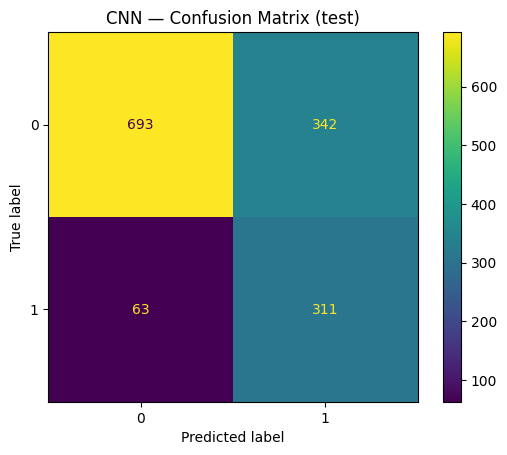

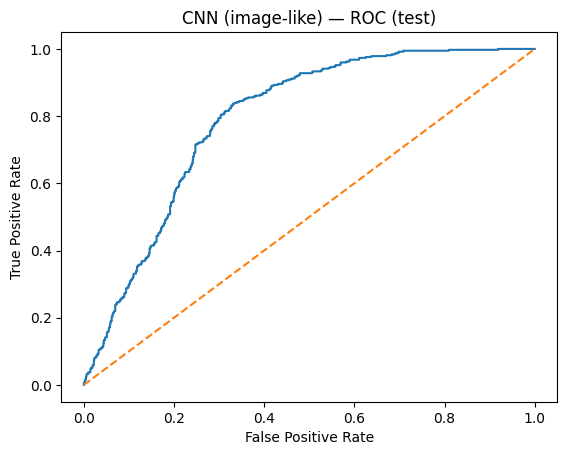

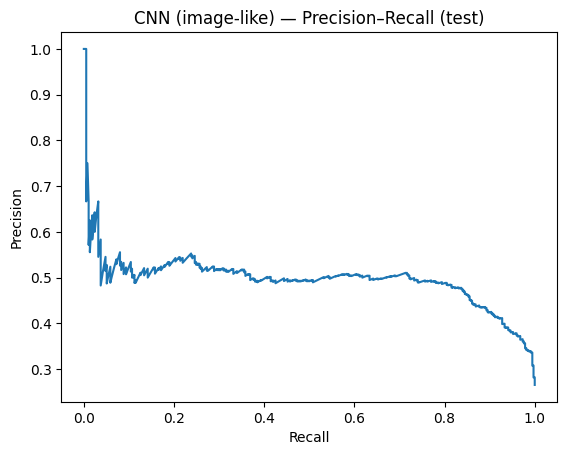

In [13]:

plot_confusion(y_test.values, y_pred_cnn, title="CNN — Confusion Matrix (test)")
plot_roc_pr(y_test.values, y_prob_cnn, title="CNN (image-like)")
